# Прямая задача

In [1]:
from math import pi
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
'''
_next - значение параметра на следующем шаге по времени
_right/_left - значение параметра в ячейке справа/слева (кроме вектора f)
_interface - значение параметра на интерфейсе (границе ячеек)
'''


def q_next(delta_x, delta_x_next, q, f, f_right, tau):
    # Расчет вектора q в правой ячейке на следующем шаге по времени
    # delta_x_next - шаг сетки по координате на следующем шаге по времени
    return (delta_x / delta_x_next) * (q - (tau / delta_x) * (f_right - f))


def f_interface(c, fi_left, fi_right, M_interface, something):
    # Расчет вектора потока f на границе ячеек (интерфейсе)
    return c / 2 * (M_interface * (fi_right + fi_left) - np.fabs(M_interface) * (fi_right - fi_left)) + something


def calculate_c_interface(c_left, c_right):
    # Расчет скорости звука на интерфейсе
    return (c_right + c_left) / 2


def mach_number_interface(v_left, v_right, u_interface, c_interface):
    # Расчет числа маха на интерфейсе
    M_left = (v_left - u_interface) / c_interface
    M_right = (v_right - u_interface) / c_interface

    return fb_plus(M_left) + fb_minus(M_right)


def calculate_p_interface(p_left, p_right, u_interface, c_interface, v_left, v_right):
    # Расчет давления на интерфейсе

    M_left = (v_left - u_interface) / c_interface
    M_right = (v_right - u_interface) / c_interface

    return ga_plus(M_left) * p_left + ga_minus(M_right) * p_right


def fb_plus(M, betta=0.125):
    fb = np.zeros_like(M)
    i = np.abs(M) >= 1
    fb[i] = ((M[i] + abs(M[i])) / 2)
    fb[~i] = ((M[~i] + 1) ** 2 * (1 + 4 * betta * (M[~i] - 1) ** 2) / 4)
    return fb

def fb_minus(M, betta=0.125):
    fb = np.zeros_like(M)
    i = np.abs(M) >= 1
    fb[i] = ((M[i] - abs(M[i])) / 2)
    fb[~i] = (-(M[~i] - 1) ** 2 * (1 + 4 * betta * (M[~i] + 1) ** 2) / 4)
    return fb

def ga_plus(M, alpha=0.1875):
    ga = np.zeros_like(M)
    i = np.abs(M) >= 1
    ga[i] = (M[i] + np.abs(M[i]) / 2 / M[i])
    ga[~i] = ((M[~i] + 1) ** 2 * ((2 - M[~i]) / 4 + alpha * M[~i] * (M[~i] - 1) ** 2))
    return ga

def ga_minus(M, alpha=0.1875):
    ga = np.zeros_like(M)
    i = np.abs(M) >= 1
    ga[i] = (M[i] - abs(M[i]) / 2 / M[i])
    ga[~i] = ((M[~i] - 1) ** 2 * ((2 + M[~i]) / 4 - alpha * M[~i] * (M[~i] + 1) ** 2))
    return ga



def direct_task(n, k, R, x_piston, x_m, m_piston, d, p_0, T, Ku):
    t = 0
    tau = 0                  # Шаг по времени
    s = (pi * d ** 2) / 4    # Площадь поп.сечения
    v_piston = 0             # Начальная скорость поршня
    delta_x = x_piston / n   # Ширина ячейки в начальный момент времени
    lst_for_tau = np.zeros(n)

    p_cell = np.zeros(n) + p_0       # Начальное значение давления газа в ячейках
    v_0 = np.zeros(n)                # Скорость газа в ячейках в начальный момент времени
    ro_0 = p_cell / (R * T)          # Плотность газа в ячейках в начальный момент времени
    E = p_cell / (ro_0 * (k-1)) + v_0**2/2      # Полная энергия в ячейках в начальный момент времени

    # Данные вектора q в начальный момент времени для каждой ячейки
    q1 = ro_0
    q2 = ro_0 * v_0
    q3 = ro_0 * E
    
    # Сюда записываются данные для графиков
    lst_v_piston = []
    lst_t = []
    lst_p_bot_tube = []
    lst_p_piston = []
    
    # Временной цикл с шагом по времени tau
    while x_piston <= x_m:
        
        v = q2 / q1   # Скорость газа в ячейках
        v_interface = np.arange(n+1) * v_piston / (n+1)
        p_cell = (q3/q1 - v ** 2 / 2) * q1 * (k-1)  # Давление в ячейках
        c_cell = np.sqrt(k * p_cell / q1)           # Скорость звука в ячейках

        # Расчет шага по времени (16)
        lst_for_tau = delta_x / (v + c_cell)
        tau = Ku * lst_for_tau.min()
        t += tau

        # в аргументах функций происходит добавление граничных условий
        c_interface = calculate_c_interface(np.append(c_cell[0], c_cell), np.append(c_cell, c_cell[-1]))
        M_interface = mach_number_interface(np.append(-v[0], v), np.append(v, 2*v_piston - v[-1]), \
                                            v_interface, c_interface)
        p_interface = calculate_p_interface(np.append(p_cell[0], p_cell), np.append(p_cell, p_cell[-1]), \
                                            v_interface, c_interface, \
                                            np.append(-v[0], v), np.append(v, 2*v_piston - v[-1]))

        H = (q3/q1) + (p_cell/q1) # Энтальпия в ячейке

        # Расчет векторов f в текущий момент времени
        f1 = f_interface(c_interface, np.append(q1[0], q1), np.append(q1, q1[-1]), M_interface, 0)
        f2 = f_interface(c_interface, np.append(-q2[0], q2), np.append(q2, -q2[-1] + 2*q1[-1]*v_piston), \
                         M_interface, p_interface)
        f3 = f_interface(c_interface, np.append(q1[0], q1)*np.append(H[0], H), np.append(q1, q1[-1])*np.append(H, H[-1]),\
                         M_interface, p_interface * v_interface)

        delta_x_next = x_piston / n

        # Расчет векторов q в текущий момент времени
        q1 = q_next(delta_x, delta_x_next, q1, f1[:-1], f1[1:], tau)
        q2 = q_next(delta_x, delta_x_next, q2, f2[:-1], f2[1:], tau)
        q3 = q_next(delta_x, delta_x_next, q3, f3[:-1], f3[1:], tau)

        delta_x = delta_x_next

        v_piston += (s / m_piston) * tau * p_cell[-1]
        x_piston += v_piston * tau
        
        # Запись данных для графика
        lst_v_piston = np.append(lst_v_piston, v_piston)
        lst_t = np.append(lst_t, t)
        lst_p_bot_tube = np.append(lst_p_bot_tube, p_interface[0])
        lst_p_piston = np.append(lst_p_piston, p_interface[-1])
        
    return v_piston, lst_t, lst_v_piston, lst_p_bot_tube, lst_p_piston

In [3]:
file_name = 'вариант36.npy'
data = np.load(file_name, allow_pickle=True)

# Данные к тестовой прямой задаче
# Длина ствола 70 калибров, начальное положение снаряда 20 калибров
# Начальная температура газа 300 К
d = data[0]*10**-3  # калибр, м
x_0 = 20*d       # Начальное положение снаряда
x_m = 70*d       # Длинна ствола
p_0 = data[15]   # Начальное давление, Па
T_0 = 300        # Начальная температура, К
m = data[16]     # масса снаряда, кг
k = 1.67         # Показатель адиабаты гелия
R = 2078         # Газовая постоянная гелия
n = 300          # Количество ячеек (по дефолту)
Ku = 0.5         # Число куранта (среднее значение)

ts = data[17]      # абсциссы точек, с
vs = data[18]      # скорости снаряда, м/с
p_dno = data[19]   # давления на дно камеры, Па
p_snar = data[20]  # давлдения на дно снаряда, Па

start_time = datetime.now()

graph_direct_task = direct_task(n, k, R, x_0, x_m, m, d, p_0, T_0, Ku)
error = round(abs(vs[-1] - graph_direct_task[0])/vs[-1] *100, 4)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))
print('Расчетная скорость -', graph_direct_task[0], 'м/с')
print('Истиное значение -', vs[-1], 'м/с')
print('Погрешность вычислений ' + str(error) + '%')

Duration: 0:00:02.351287
Расчетная скорость - 535.992916272486 м/с
Истиное значение - 536.233384417661 м/с
Погрешность вычислений 0.0448%


In [4]:
print(m)

0.03828948332104999


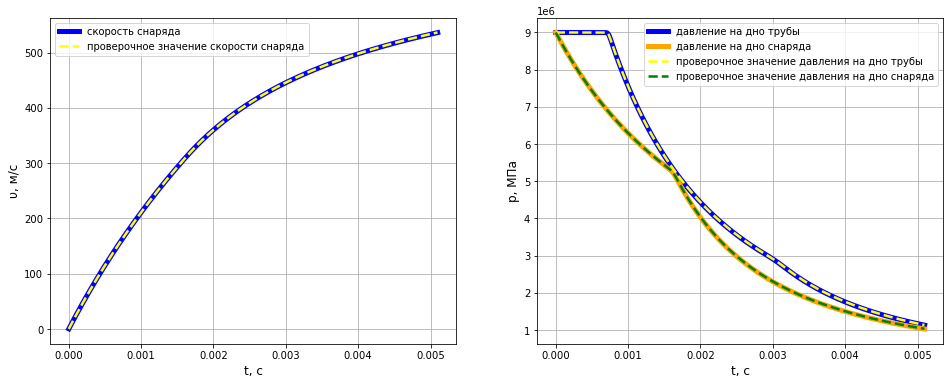

In [5]:
plt.figure(figsize=(16,6))

plt.subplot(1, 2, 1)
plt.plot(graph_direct_task[1], graph_direct_task[2], color='blue', linestyle='-', linewidth=5, label='скорость снаряда')
plt.plot(ts, vs, color='yellow', linestyle='--', linewidth=2.5, label='проверочное значение скорости снаряда')
plt.ylabel('υ, м/c', size=12)
plt.xlabel('t, c', size=12)
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(graph_direct_task[1], graph_direct_task[3], color='blue', linewidth=5, label='давление на дно трубы')
plt.plot(graph_direct_task[1], graph_direct_task[4], color='orange', linewidth=5, label='давление на дно снаряда')
plt.plot(ts, p_dno, color='yellow', linestyle='--', linewidth=2.5, label='проверочное значение давления на дно трубы')
plt.plot(ts, p_snar, color='green', linestyle='--', linewidth=2.5, label='проверочное значение давления на дно снаряда')
plt.ylabel('p, МПа', size=12)
plt.xlabel('t, c', size=12)
plt.grid(True)
plt.legend()

plt.show()

# Задача сода

In [6]:
def sodas_task(d, T, k, R, p_1, u_1, p_2, u_2, time_x, x_0, length, n, Ku):
    t = 0
    tau = 0                  # Шаг по времени
    s = (pi * d ** 2) / 4    # Площадь поп.сечения
    delta_x = length / n     # Ширина ячейки в начальный момент времени
    
    indices = np.arange(n)
    i = indices < int(n * x_0/length)  # Маска для ячеек слева и справа

    p_cell = np.zeros(n)
    v_0 = np.zeros(n)
    lst_for_tau = np.zeros(n)
    x = np.linspace(0, length, n)
    
    v_0[i] = u_1                 # Начальная скорость газа в ячейках слева
    v_0[~i] = u_2                # Начальная скорость газа в ячейках справа
    p_cell[i] = p_1              # Начальное значение давления газа в ячейках слева
    p_cell[~i] = p_2             # Начальное значение давления газа в ячейках справа
    ro = p_cell / (R * T)        # Плотность газа в ячейках в начальный момент времени
    E = p_cell / (ro * (k-1)) + v_0**2/2    # Удельная внутренняя энергия в ячейках в начальный момент времени

    # Данные вектора q в начальный момент времени для каждой ячейки
    q1 = ro
    q2 = ro * v_0
    q3 = ro * E
    
    v_piston = u_2    # Скорость правой границы равна скорости газа
    x_piston = x[-1]
    # Временной цикл с шагом по времени tau
    while t <= time_x:
        
        v = q2 / q1     # Скорость газа в ячейках
        v_interface = np.arange(n+1) * v_piston / (n+1)  # Т.к. правая граница движется, то и интерфейсы тоже
        p_cell = (q3/q1 - v ** 2 / 2) * q1 * (k-1)       # Давление в ячейках
        c_cell = np.sqrt(k * p_cell / q1)                # Скорость звука в ячейках

        # Расчет шага по времени (16)
        lst_for_tau = delta_x / (np.abs(v) + c_cell)
        tau = Ku * lst_for_tau.min()
        t += tau

        # в аргументах функций происходит добавление граничных условий
        c_interface = calculate_c_interface(np.append(c_cell[0], c_cell), np.append(c_cell, c_cell[-1]))
        M_interface = mach_number_interface(np.append(-v[0], v), np.append(v, 2*v_piston - v[-1]), \
                                            v_interface, c_interface)
        p_interface = calculate_p_interface(np.append(p_cell[0], p_cell), np.append(p_cell, p_cell[-1]), \
                                            v_interface, c_interface, \
                                            np.append(-v[0], v), np.append(v, 2*v_piston - v[-1]))

        H = (q3/q1) + (p_cell/q1) # Энтальпия в ячейках

        # Расчет векторов f в текущий момент времени
        f1 = f_interface(c_interface, np.append(q1[0], q1), np.append(q1, q1[-1]), M_interface, 0)
        f2 = f_interface(c_interface, np.append(-q2[0], q2), np.append(q2, -q2[-1] + 2*q1[-1]*v_piston), \
                         M_interface, p_interface)
        f3 = f_interface(c_interface, np.append(q1[0], q1)*np.append(H[0], H), np.append(q1, q1[-1])*np.append(H, H[-1]),\
                         M_interface, p_interface * v_interface)
        
        x_piston += v_piston * tau          
        delta_x_next = x_piston / n

        # Расчет векторов q в текущий момент времени
        q1 = q_next(delta_x, delta_x_next, q1, f1[:-1], f1[1:], tau)
        q2 = q_next(delta_x, delta_x_next, q2, f2[:-1], f2[1:], tau)
        q3 = q_next(delta_x, delta_x_next, q3, f3[:-1], f3[1:], tau)
        
        delta_x = delta_x_next
        
    c_cell = np.sqrt(k * p_cell / q1)
    x = np.linspace(0, x_piston, n)
    
    return x, q1, (q3/q1 - v ** 2 / 2) * q1 * (k-1), q2 / q1, q3/q1 - (q2 / q1)**2/2, q2 / q1 / c_cell

In [7]:
file_name = 'вариант36.npy'
data = np.load(file_name, allow_pickle=True)
# Данные к задаче распада разрыва
# Начальная температура газа 300 К 
d = data[0]          # калибр, мм
gas_type = data[1]   # тип газа (У 36 варианта гелий)
T = 300              # Начальная температура
k = 1.67             # Показатель адиабаты гелия
R = 2078             # Газовая постоянная гелия
p_1 = data[2]        # давление в области слева, Па
u_1 = data[3]        # скорость газа в области слева, м/с
p_2 = data[4]        # давление в области справа, Па
u_2 = data[5]        # скорость газа в области справа, м/с
time_x = data[6]     # контрольное время, с
x_0 = data[7]        # положение разрыва в начальный момент времени, м
length = data[8]     # длинна области, м
n = 10000            # Количество ячеек
Ku = 0.3             # Число куранта

xs = data[9]        # абсциссы точек данных распределений, м
ros = data[10]      # распределение плотностей, кг/м^3
ps = data[11]       # распределение давлений, Па
us = data[12]       # распределение скоростей, м/с
es = data[13]       # распределение удельных энергий, м^2/c^2
ms = data[14]       # распределение чисел маха, -

start_time = datetime.now()

graph_soda = sodas_task(d, T, k, R, p_1, u_1, p_2, u_2 , time_x, x_0, length, n, Ku)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:27.159630


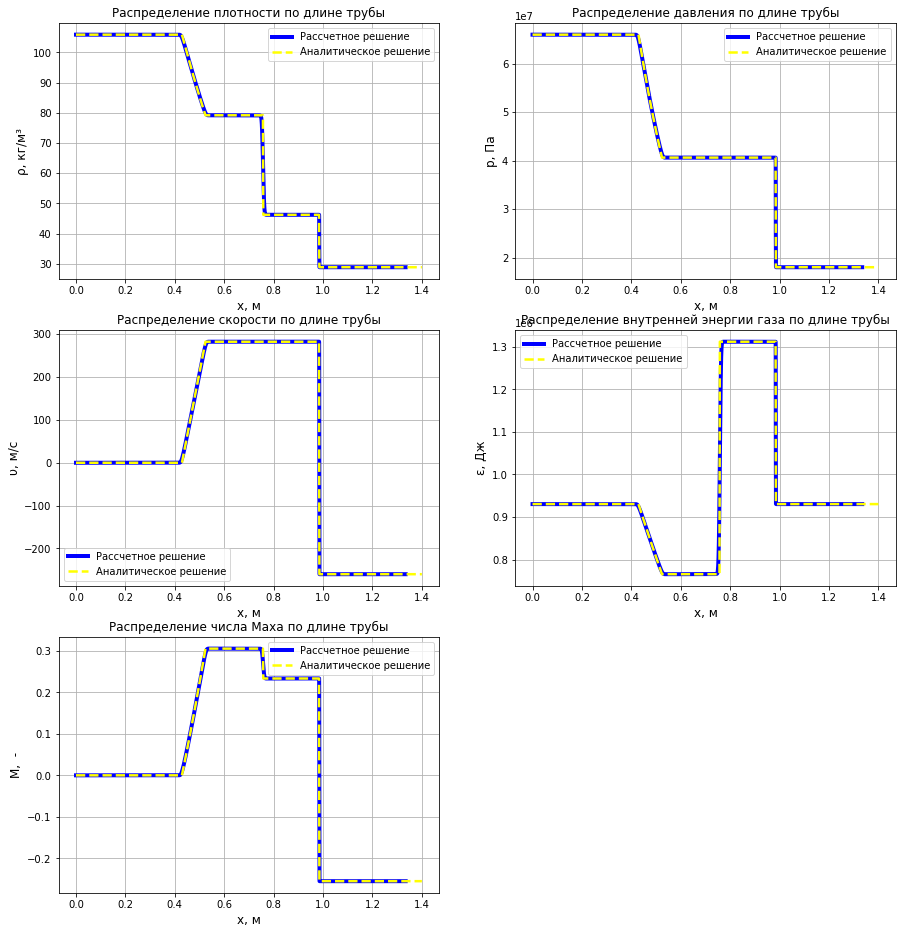

In [8]:
plt.figure(figsize=(15,16))

plt.subplot(3, 2, 1)
plt.plot(graph_soda[0], graph_soda[1], color='blue', linestyle='-', linewidth=4, label='Рассчетное решение')
plt.plot(xs, ros, color='yellow', linestyle='--', linewidth=2.5, label='Аналитическое решение')
plt.ylabel('ρ, кг/м³', size=12)
plt.xlabel('x, м', size=12)
plt.grid(True)
plt.legend()
plt.title('Распределение плотности по длине трубы')

plt.subplot(3, 2, 2)
plt.plot(graph_soda[0], graph_soda[2], color='blue', linestyle='-', linewidth=4, label='Рассчетное решение')
plt.plot(xs, ps, color='yellow', linestyle='--', linewidth=2.5, label='Аналитическое решение')
plt.ylabel('p, Па', size=12)
plt.xlabel('x, м', size=12)
plt.grid(True)
plt.legend()
plt.title('Распределение давления по длине трубы')

plt.subplot(3, 2, 3)
plt.plot(graph_soda[0], graph_soda[3], color='blue', linestyle='-', linewidth=4, label='Рассчетное решение')
plt.plot(xs, us, color='yellow', linestyle='--', linewidth=2.5, label='Аналитическое решение')
plt.ylabel('υ, м/с', size=12)
plt.xlabel('x, м', size=12)
plt.grid(True)
plt.legend()
plt.title('Распределение скорости по длине трубы')

plt.subplot(3, 2, 4)
plt.plot(graph_soda[0], graph_soda[4], color='blue', linestyle='-', linewidth=4, label='Рассчетное решение')
plt.plot(xs, es, color='yellow', linestyle='--', linewidth=2.5, label='Аналитическое решение')
plt.ylabel('ε, Дж', size=12)
plt.xlabel('x, м', size=12)
plt.grid(True)
plt.legend()
plt.title('Распределение внутренней энергии газа по длине трубы')

plt.subplot(3, 2, 5)
plt.plot(graph_soda[0], graph_soda[5], color='blue', linestyle='-', linewidth=4, label='Рассчетное решение')
plt.plot(xs, ms, color='yellow', linestyle='--', linewidth=2.5, label='Аналитическое решение')
plt.ylabel('М,  -', size=12)
plt.xlabel('x, м', size=12)
plt.grid(True)
plt.legend()
plt.title('Распределение числа Маха по длине трубы')

plt.show()

# Обратная задача

Найдем оптимальное значение длины камеры для получения максимальной скорости вылета снаряда

In [12]:
d = 0.037
x_m = 45*d
p_0 = 40*10**6
k = 1.67
R = 2078
T_0 = 500
n = 300
Ku = 0.4
lenght = np.linspace(0, 0.92*x_m, 21)
lst_v_test = []
lst_v_test_answer = []

m = 0.1
for x_0 in lenght[1:]:
    v = direct_task(n, k, R, x_0, x_m, m, d, p_0, T_0, Ku)[0]
    lst_v_test.append(v)

m = 0.4332
for x_0 in lenght[1:]:
    v = direct_task(n, k, R, x_0, x_m, m, d, p_0, T_0, Ku)[0]
    lst_v_test_answer.append(v)

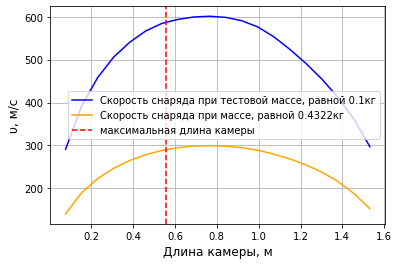

In [15]:
plt.plot(lenght[1:], lst_v_test, color='blue', linestyle='-', label='Скорость снаряда при тестовой массе, равной 0.1кг')
plt.plot(lenght[1:], lst_v_test_answer, color='orange', linestyle='-', label='Скорость снаряда при массе, равной 0.4322кг')
plt.axvline(x=x_m/3, color='red', linestyle='--', label='максимальная длина камеры ')
plt.ylabel('υ, м/c', size=12)
plt.xlabel('Длина камеры, м', size=12)
plt.grid(True)
plt.legend()
plt.show()

In [16]:
start_time = datetime.now()

d = 0.037
v_piston = 290
x_m = 45*d
x_0 = x_m/3  # т.к. при таком значении достигается максимальная скорость вылета снаряда
p_0 = 40*10**6
k = 1.67
R = 2078
T_0 = 500
n = 300
Ku = 0.5

m = 0.1    # Масса снаряда, с которой начинается перебор
h = 0.1    # Начальный шаг по массе
lst_m = []
lst_v = []

i = 4      # Ответ будет с точностью до стольки знаков после запятой
for _ in range(i):
    v = direct_task(n, k, R, x_0, x_m, m, d, p_0, T_0, Ku)[0]
    while v > v_piston:
        lst_m.append(round(m, i))
        lst_v.append(round(v, i))
        m += h
        v = direct_task(n, k, R, x_0, x_m, m, d, p_0, T_0, Ku)[0]
    else:
        m -= h    # Откат к последнему подходящему значению массы
        h /= 10   
        m += h

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

for i, m in enumerate(lst_m):
    print(m, '-', lst_v[i])
print('Максимальная масса метаемого тела равна', m, 'кг')

Duration: 0:01:11.473953
0.1 - 587.0974
0.2 - 422.3826
0.3 - 347.3496
0.4 - 301.5322
0.41 - 297.9172
0.42 - 294.4227
0.43 - 291.0777
0.431 - 290.7328
0.432 - 290.4258
0.433 - 290.0837
0.4331 - 290.0677
0.4332 - 290.0155
Максимальная масса метаемого тела равна 0.4332 кг


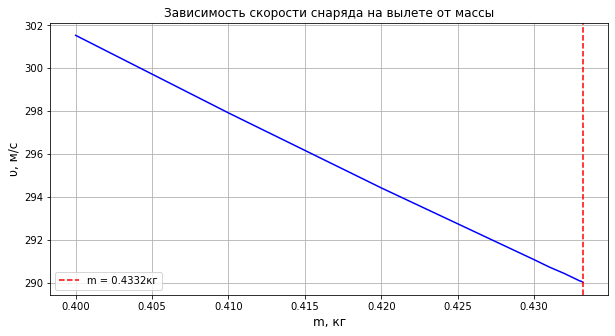

In [21]:
plt.figure(figsize=(10,5))
plt.plot(lst_m[3:], lst_v[3:], color='blue', linestyle='-')
plt.axvline(x=m, color='red', linestyle='--', label='m = 0.4332кг')
plt.ylabel('υ, м/c', size=12)
plt.xlabel('m, кг', size=12)
plt.grid(True)
plt.legend()
plt.title('Зависимость скорости снаряда на вылете от массы')
plt.show()

In [33]:
d = 0.037
v_piston = 290
x_m = 45*d
x_0 = x_m/3  # т.к. при таком значении достигается максимальная скорость вылета снаряда
p_0 = 40*10**6
k = 1.67
R = 2078
T_0 = 500
n = 300
Ku = 0.5
m = max(lst_m)

check = direct_task(n, k, R, x_0, x_m, m, d, p_0, T_0, Ku)
check[0]

290.0154864281301

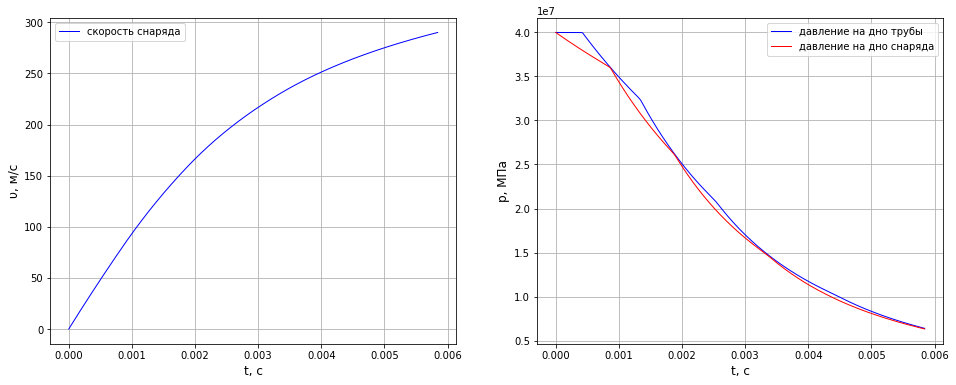

In [41]:
plt.figure(figsize=(16,6))

plt.subplot(1, 2, 1)
plt.plot(check[1], check[2], color='blue', linestyle='-', linewidth=1, label='скорость снаряда')
plt.ylabel('υ, м/c', size=12)
plt.xlabel('t, c', size=12)
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(check[1], check[3], color='blue', linewidth=1, label='давление на дно трубы')
plt.plot(check[1], check[4], color='red', linewidth=1, label='давление на дно снаряда')
plt.ylabel('p, МПа', size=12)
plt.xlabel('t, c', size=12)
plt.grid(True)
plt.legend()

plt.show()